In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

import tensorflow as tf
# from tensorflow.python import keras
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import optimizers
# from tensorflow.python.keras.models import load_model
# tf.config.run_functions_eagerly(True)

import matplotlib.pyplot as plt 
# from scipy.stats import norm

from pickle import dump

# from models import resnet
from models import transformer

In [3]:
# load data
data = pd.read_csv("../data/csv/data.csv", sep = ",")
print(data.dtypes)

race_id                 int64
race_round              int64
ground_condition        int64
total_horse_number      int64
order                   int64
                       ...   
ground_type_芝_3       float64
ground_type_障_3       float64
horse_weight_dif_3    float64
same_jockey_3         float64
same_jockey           float64
Length: 150, dtype: object


In [4]:
# adjust columns type
data['race_id'] = data['race_id'].astype(str)
# data['race_round'] = data['race_round'].astype(str)
# #data['total_horse_number'] = data['total_horse_number'].astype(str)
data['order'] = data['order'].astype(str)
# data['frame_number'] = data['frame_number'].astype(str)
# data['horse_number'] = data['horse_number'].astype(str)


In [5]:
# delete race day information
data = data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1)
# "race_round",

In [6]:
# standarlization 
no_scale_data = data[['race_id','order']]
scale_columns = data.drop(['race_id','order'], axis=1).columns.values
standard_scale = StandardScaler()
data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))
data = pd.concat([data, no_scale_data], axis=1)
dump(standard_scale, open("standard_scale.pkl", "wb"))

In [7]:
# # creating time series data
# def return_one_race(all_horse):
#     print(len(all_horse))
#     one_race = np.full((18, 139), -float('inf'))
# #     print(len(one_race))
# #     print(len(one_race[0]))
#     for i, one_horse in all_horse.iterrows():
#         print(i)
# #         print(one_horse)
#         one_race[i] = one_horse.drop(['race_id']).values
#     print(one_race)
#     return one_race

# def create_time_series_data(raw_data):
#     time_series_data = []
#     time_series_data.append(raw_data.groupby(['race_id']).apply(return_one_race))
#     return time_series_data

In [8]:
print(data.shape)
print(data.dtypes)
print(data.head(20))

(92033, 142)
0          float64
1          float64
2          float64
3          float64
4          float64
            ...   
137        float64
138        float64
139        float64
race_id     object
order       object
Length: 142, dtype: object
           0         1         2         3         4         5         6  \
0   0.434374 -0.509915 -0.220628  1.545825 -0.874906  2.530312 -0.385375   
1   0.434374 -0.509915 -0.220628  0.089023 -0.874906 -0.643375 -0.385375   
2   0.434374 -0.509915 -0.220628  0.817424 -0.255801 -0.554265 -0.385375   
3   0.434374 -0.509915 -0.220628  1.545825  0.363305 -0.491203 -0.385375   
4   0.434374 -0.509915 -0.220628  0.817424 -0.874906 -0.591280 -0.385375   
5   0.434374 -0.509915 -0.220628  0.089023 -0.874906 -0.563862 -0.385375   
6   0.434374 -0.509915 -0.220628  0.089023 -0.874906 -0.484348 -0.385375   
7   0.434374 -0.509915 -0.220628  0.089023 -0.874906 -0.456930 -0.385375   
8   0.434374 -0.509915 -0.220628  0.089023 -0.255801 -0.439108 -0.3

In [9]:
def create_time_series_data(raw_data):
    number_of_race = raw_data.race_id.nunique()
    time_series_data = np.full((number_of_race, 18, 140), -float('inf'))
    label = np.full((number_of_race, 18), 19)
    race_number = 0
    horse_number = 0
    for i in range(len(raw_data)):
        if i == 0:
#             print(race_number)
#             print(horse_number)
#             print(raw_data.iloc[i].order)
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
            continue
        if data.iloc[i].race_id != data.iloc[i-1].race_id:
            race_number += 1
            horse_number = 0
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
        else:
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
    return time_series_data, label

In [10]:
X, y_order = create_time_series_data(data)
print(X.shape)
print(y_order.shape)

(8489, 18, 140)
(8489, 18)


In [11]:
X = X.astype('float32')
print(X.dtype)

float32


In [12]:
print(X[0][11])
print(y_order[0])

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 5  2 11  7  1  6  3  8  4 12 14 19 19 19 19 19 19 19]


In [13]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[0])
print(X.shape)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

AxesSubplot(0.125,0.125;0.775x0.755)


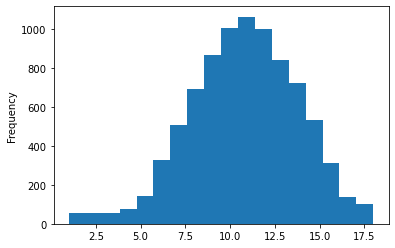

In [14]:
print(data.race_id.value_counts().plot.hist(bins=18,range=(1,18)))

AxesSubplot(0.125,0.125;0.775x0.755)


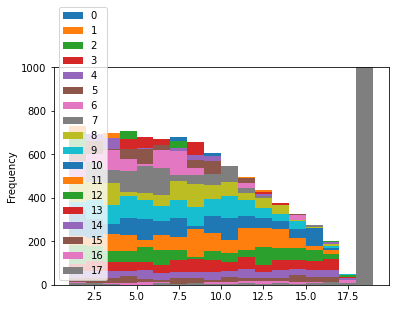

In [15]:
print(pd.DataFrame(y_order).plot.hist(bins=18, ylim=(0,1000)))

In [16]:
# BUFFER_SIZE = 1000
# BATCH_SIZE = 128
# def make_batches(ds):
#     return (
#       ds
# #       .cache()
# #       .shuffle(BUFFER_SIZE)
#       .batch(BATCH_SIZE)
# #       .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
#       .prefetch(tf.data.AUTOTUNE))

# X = tf.convert_to_tensor(X)
# y = tf.convert_to_tensor(y)
# X = make_batches(X)
# y = make_batches(y)

In [17]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [18]:
print(X_train[0][0])

[-1.3145431  -0.50991476  0.5901306   0.089023    0.3633046  -0.555636
 -0.38537532  0.8550409  -0.7798238   0.7798238   0.6798608  -0.66338956
 -0.18337315 -0.02931084 -1.3091208   1.597206   -0.23655261 -0.02236226
 -0.24513794  2.2255282  -0.4990219  -0.17550196 -0.2203592  -0.25591546
 -0.17979759 -0.49679595 -0.19606745 -0.4557965  -0.22428839 -0.71253043
  0.7906001  -1.1524768  -0.4643385  -1.249982   -0.29165798 -0.1354737
 -0.29401696  0.5838889  -0.4724972   0.4967511  -1.3390157  -0.53560555
  0.6186662   0.98761696  0.8457565  -0.5208136   0.7919285  -1.0952293
  0.4266353   1.6640126  -0.18337315 -0.03058303 -1.3037888   1.5938668
 -0.23864526 -0.02422995 -0.1135239  -0.25064442  2.2850358  -0.487239
 -0.18498135 -0.24115273 -0.26462567 -0.18406838 -0.47511455 -0.2061855
 -0.44352028 -0.37101352 -0.7890041   0.79361564 -0.0526072   0.20228021
 -0.685882   -0.52846843 -0.49079907 -0.6400163   1.0059242   1.368932
 -0.52115315  1.2905855  -1.249058    0.10102149  1.6128289  

In [19]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6791, 18, 140)
(1698, 18, 140)
(6791, 18, 20)
(1698, 18, 20)


In [53]:
# creating dataset with batch size
batch_size = 2048
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=6791).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=1698).batch(batch_size)

In [65]:
# set up parameters
num_layers = 1
d_model = 140
num_heads = 1
d_ffn = 8
pe_input = 18
target_size = 20
dropout_rate = 0.5

In [66]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
)

# trans_race.build(input_shape=(None,18,139))
opt = optimizers.Adam(lr = 0.0001, clipvalue = 2.)
trans_race.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [67]:
history = trans_race.fit(
                        X_train, 
                        y_train,
                        validation_data=([X_valid, y_valid]),
                        epochs=1,
#                         callbacks=[early_stopping],
                        verbose=True, # hide the output because we have so many epochs
                        )
trans_race.save_weights("../models/results/transfomer1.h5")

# the problem is gradient exploding

mask shape after creating (?, 1, 1, 18, 140)
(?, 18, 140) mha
(?, 18, 1, 140) split_head
(?, 18, 1, 140) split_head
(?, 18, 1, 140) split_head
(?, 1, 18, 140) scaled_dot_
(?, 1, 18, 18) scaled_attention_shape
Train on 6791 samples, validate on 1698 samples


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [32,18,20] vs. [32,18,18]
	 [[{{node training_6/gradients/loss_3/output_1_loss/mul_grad/BroadcastGradientArgs}}]]
  (1) Invalid argument: Incompatible shapes: [32,18,20] vs. [32,18,18]
	 [[{{node training_6/gradients/loss_3/output_1_loss/mul_grad/BroadcastGradientArgs}}]]
	 [[loss_3/mul/_1443]]
0 successful operations.
0 derived errors ignored.

In [ ]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='upper right')
# figureの保存
plt.savefig("../models/results/trans_race_result.png")

In [ ]:
l1 = trans_race.layers[0]
print(l1.get_weights()[0])

In [ ]:
# predict
from tensorflow.keras import backend

pred = trans_race(X_valid, training=False)
# print(backend.eval(pred))
pred = backend.eval(pred)
y_pred = np.argmax(pred, axis = 2)
y_ans = np.argmax(y_valid, axis = 2)


In [ ]:
print(pred.shape)
print(y_pred.shape)
print(y_ans.shape)

In [61]:
print(y_ans[0])
print(y_pred[1])
print(np.mean(y_pred))

[ 8 10  9  3  4  7  5  6  1  2 19 19 19 19 19 19 19 19]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.08532914539981677


In [62]:
X_valid[10]

array([[ 0.43437406, -0.50991476,  1.400889  , ...,  1.7612689 ,
        -0.5135207 , -0.685882  ],
       [ 0.43437406, -0.50991476,  1.400889  , ...,  0.20064315,
        -0.5135207 , -0.685882  ],
       [ 0.43437406, -0.50991476,  1.400889  , ..., -0.11148198,
        -0.5135207 , -0.685882  ],
       ...,
       [ 0.43437406, -0.50991476,  1.400889  , ...,  1.4491436 ,
        -0.5135207 , -0.685882  ],
       [ 0.43437406, -0.50991476,  1.400889  , ...,  0.20064315,
         1.9473411 ,  1.4579768 ],
       [       -inf,        -inf,        -inf, ...,        -inf,
               -inf,        -inf]], dtype=float32)

In [63]:
correct = 0
for i in range(len(y_pred)):
    for j in range(len(y_pred[0])):
        if (y_pred[i][j] == y_ans[i][j]):
            correct += 1
accuracy = correct / len(y_pred)
print("accuracy: ", accuracy)

accuracy:  0.007067137809187279


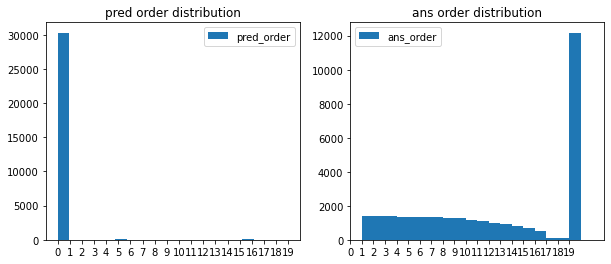

In [64]:
# 何位に予想した？　何位が含まれていた？
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']

axL.hist(y_pred.flatten(), bins = 20, label = "pred_order")##, range = (1,21)
axL.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(y_ans.flatten(), bins = 20, label = "ans_order", range = (1,21))
axR.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [52]:
# print(np.unique(pred_order))
# print(np.unique(Y_ans))
# u, c = np.unique(pred_order, return_counts = True)
# print(u)
# print(c)

In [ ]:
# accuracy of the first horse
i = 0
correct_first = 0
all_f = 0
increase = 0
X_test_inv = standard_scale.inverse_transform(X_test)
X_test_inv_df = pd.DataFrame(X_test_inv)
odds = X_test_inv_df[4].values
hit_odds = []
select = []

for i in range(len(Y_ans)):
    if (pred_order[i] == 1):  # いちい予想した総数  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
        all_f = all_f + 1
        if (Y_ans[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            increase += odds[i]
            hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
print("hit odds average: ", np.array(hit_odds).mean())
print("spent money:", all_f * 100)
revenue = (increase - all_f) * 100
retrive = increase / all_f
 
print("retrive rate: ", retrive) 
print("revenue: ", revenue)
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
#print("\n".join(map(str,hit_odds)))
print("min: ", min(hit_odds))
print("mid: ", np.median(np.array(hit_odds)))
print("max: ", max(hit_odds))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(hit_odds, bins = 50, label = "hit_odds")
axL.set_title('hit odds distribution')
axL.legend()
axR.hist(odds, bins = 50, label = "odds", range = (0,40))
axR.set_title('all odds distribution')
axR.legend()
fig.show()


In [ ]:
# 一位だった時一位予想していた確率
i = 0
correct_first = 0
all_f = 0
odds_f = []
p_rate_f = []

all_f_odds = []

for i in range(len(Y_ans)):
    if (Y_ans[i] == 1):  # 一位の総数
        all_f = all_f + 1
        all_f_odds.append(odds[i])
        if (pred_order[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            odds_f.append(odds[i])
            p_rate_f.append(pred[i][1])

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.scatter(p_rate_f, odds_f)  
axL.set_title('correlation odss and prediction')
#axL.xlabel('prediction rate first')
#axL.ylabel('odds')
axR.hist(odds_f, bins = 50, label = "odds")
axR.set_title('all first odds distribution')
axR.legend()

fig.show()
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
print("all_f_odds average: ", np.array(all_f_odds).mean())



ensamble log

In [ ]:
model1 = resnet.resrace(X_test.shape[1], 19)
model1.load_weights("model/win5_resrace_model_best1.h5")
pred1 = model1.predict(X_test)

In [ ]:
model2 = resnet.resrace(X_test.shape[1], 19)
model2.load_weights("model/win5_resrace_model_best2.h5")
pred2 = model2.predict(X_test)

In [ ]:
model3 = resnet.resrace(X_test.shape[1], 19)
model3.load_weights("model/win5_resrace_model_best3.h5")
pred3 = model3.predict(X_test)

In [ ]:
model4 = resnet.resrace(X_test.shape[1], 19)
model4.load_weights("model/win5_resrace_model_best4.h5")
pred4 = model4.predict(X_test)

In [ ]:
model5 = resnet.resrace(X_test.shape[1], 19)
model5.load_weights("model/win5_resrace_model_best5.h5")
pred5 = model5.predict(X_test)

In [ ]:
model6 = resnet.resrace(X_test.shape[1], 19)
model6.load_weights("model/win5_resrace_model_best6.h5")
pred6 = model6.predict(X_test)

In [ ]:
model7 = resnet.resrace(X_test.shape[1], 19)
model7.load_weights("model/win5_resrace_model_best7.h5")
pred7 = model7.predict(X_test)

In [ ]:
model8 = resnet.resrace(X_test.shape[1], 19)
model8.load_weights("model/win5_resrace_model_best8.h5")
pred8 = model8.predict(X_test)

In [ ]:
model9 = resnet.resrace(X_test.shape[1], 19)
model9.load_weights("model/win5_resrace_model_best9.h5")
pred9 = model9.predict(X_test)

In [ ]:
model10 = resnet.resrace(X_test.shape[1], 19)
model10.load_weights("model/win5_resrace_model_best10.h5")
pred10 = model10.predict(X_test)

In [ ]:
log_pred1 = np.log(pred1)
log_pred2 = np.log(pred2)
log_pred3 = np.log(pred3)
log_pred4 = np.log(pred4)
log_pred5 = np.log(pred5)
# log_pred6 = np.log(pred6)
# log_pred7 = np.log(pred7)
# log_pred8 = np.log(pred8)
# log_pred9 = np.log(pred9)
# log_pred10 = np.log(pred10)

sum_pred = log_pred1 + log_pred2 + log_pred3 + log_pred4 + log_pred5 #+ log_pred6 + log_pred7 + log_pred8 + log_pred9 + log_pred10
pred_order = np.argmax(sum_pred, axis = 1)

In [ ]:
# print(sum_pred[:5])

In [ ]:
# print(pred_order[:5])